# Model Data

Here we will work with prepared data and try find answers to the 3 questions:
#### * Should we have planned more time for the transfer?

#### * Which of the three airports has best reachability from the quarter where we stayed this time?

#### * Which quarter has best reachability to Newark Airport?


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
#sns.set_style('ticks')
%config InlineBackend.figure_format = 'retina'
from matplotlib.pyplot import figure
from IPython.display import Markdown as md
import math

Lets load our prepared data:

In [65]:
df = pd.read_pickle('nyc-2017-yellow-taxi-trips-to-airport-transformed.pkl.gz')

## Some more cleaning

In [66]:
df.isna().sum()

pickup_datetime          0
dropoff_datetime         0
trip_distance            0
pickup_borough           0
pickup_zone              0
dropoff_zone             0
pickup_service_zone      0
dropoff_month            0
drop_off_week_of_year    0
dropoff_day_of_year      0
dropoff_day_of_month     0
dropoff_weekday          0
dropoff_is_weekend       0
dropoff_hour             0
trip_duration_minutes    0
trip_duration_hours      0
trip_velocity            0
dtype: int64

No missing values.
We did already some cleaning in the preparation phase.
Looks like that was good enough.

Lets check our new variable for velocity.

In [67]:
df.trip_velocity.describe()

count    2.509468e+06
mean     4.795880e+01
std      6.616499e+02
min      0.000000e+00
25%      1.648739e+01
50%      2.206076e+01
75%      2.877454e+01
max      9.864000e+04
Name: trip_velocity, dtype: float64

Hoho ... maximum value of 98,000 miles per hours. Thats fast.

Lets see how many trips were faster than 70 miles per hours.

In [68]:
df[df.trip_velocity > 70].shape

(16095, 17)

How many is this in percent of all rows?

In [69]:
100*df[df.trip_velocity > 70].shape[0] / df.shape[0]

0.6413709997497478

Less than 1%, so lets drop them. Now we got rid of ~16000 inplausible data rows.

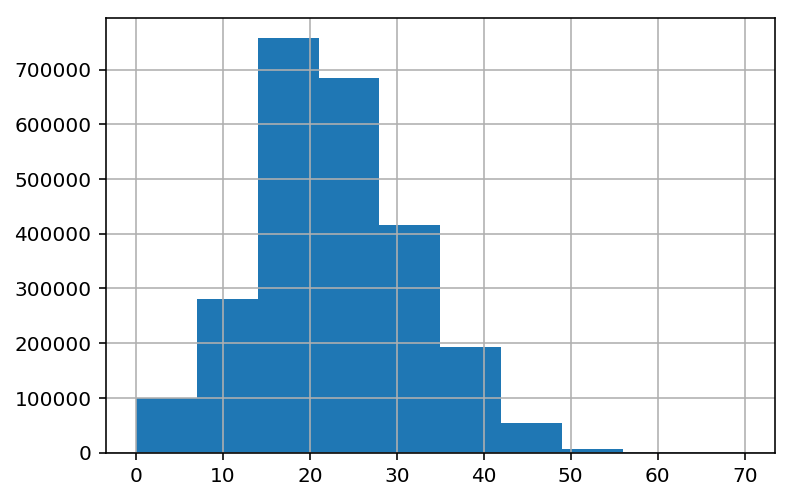

In [70]:
df = df[df.trip_velocity <= 70]
df.trip_velocity.hist()


The velocity distribution looks sane now.

## Question 1: Should we have planned more time for the transfer?

I will have a look how trip duration is distributed.

In [71]:
def duration_hist(df, title, y_scale_log=False, cumulative=False):
    figure(figsize=(6,3))
    maxmins = int(df.trip_duration_minutes.max())
    step = 10**math.ceil(math.log10(maxmins/50))
    if maxmins/step < 10:
        step = int(step/2)
    df.trip_duration_minutes.hist(bins=range(0, maxmins, step),
                                  rwidth=.9, align='mid')
    if y_scale_log:
        plt.yscale('log')
    plt.xlabel('trip duration in minutes')
    plt.ylabel('count of trips')
    plt.xticks(range(0, maxmins, step), rotation=90);
    plt.title(("{:,} " + title).format(df.shape[0]))
    plt.savefig(title.replace(' ','_')+'.png', dpi=1200)

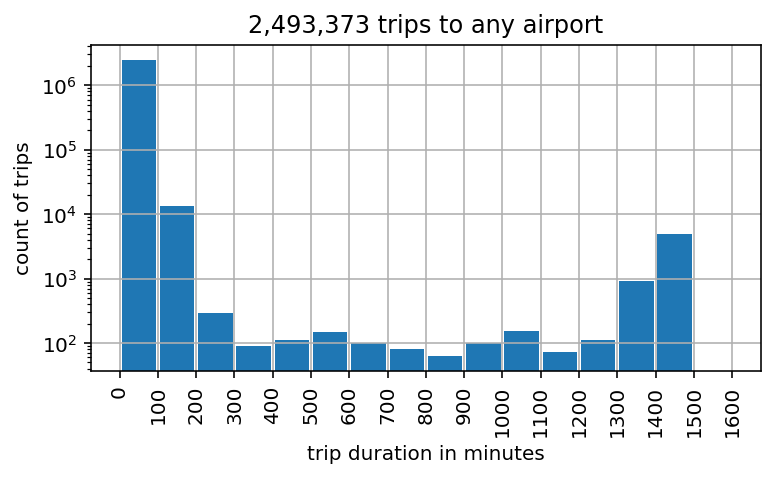

In [72]:
duration_hist(df, "trips to any airport", y_scale_log=1)

Thats strange, some trips took more than 10 hours? How many of them? 

In [73]:
(df.trip_duration_minutes > 600).sum(), (df.trip_duration_minutes > 600).mean()

(6532, 0.002619744418504572)

I decide to drop all that take longer than 10 hours, since there are not so many.

In [74]:
df = df[df.trip_duration_minutes <= 600]

Until now we looked at all yellow taxi trips: starting at any zone in NYC, heading to any airport.

How many trips were headed to each airport?

In [75]:
airports = dict();
for name in df.dropoff_zone.unique().astype('str'):
    airports[name] = df[df.dropoff_zone == name].shape[0]


In [76]:
txt = "In 2017 there were {:,} Yellow Taxi trips to one of the three airports:\n"
for airport, no_of_trips in airports.items():
    txt += "* {}: {:,}\n"
md(txt.format(df.shape[0], 'Newark Airport', airports['Newark Airport'],
                           'JFK Airport', airports['JFK Airport'],
                           'LaGuardia Airport', airports['LaGuardia Airport'],
             ))

In 2017 there were 2,486,841 Yellow Taxi trips to one of the three airports:
* Newark Airport: 214,613
* JFK Airport: 967,731
* LaGuardia Airport: 1,304,497


Actually I am interested in trips heading to Newark Airport, our pickup zone was Murray Hill and the trip was at friday.
Lets define bunch of restricted datasets, so that we can zoom in to a smaller and smaller set of trips.

In [77]:
# EWR = Newark Airport
# JFK = JFK Airport
# LGA = LaGuardia Airport
# MH = Murray Hill
# WD = weekday
# FR = friday
df_ewr = df[df.dropoff_zone == 'Newark Airport']
df_mh_ewr = df_ewr[df_ewr.pickup_zone == 'Murray Hill']
df_mh_jfk = df[(df.pickup_zone == 'Murray Hill') & (df.dropoff_zone == 'JFK Airport')]
df_mh_lga = df[(df.pickup_zone == 'Murray Hill') & (df.dropoff_zone == 'LaGuardia Airport')]
df_mh_ewr_wd = df_mh_ewr[df_mh_ewr.dropoff_is_weekend == False]
df_mh_ewr_fr = df_mh_ewr[df_mh_ewr.dropoff_datetime.dt.day == 4]

First lets have a look again at the set of all trips, after dropping the ones with a duration of 10 hours or more.

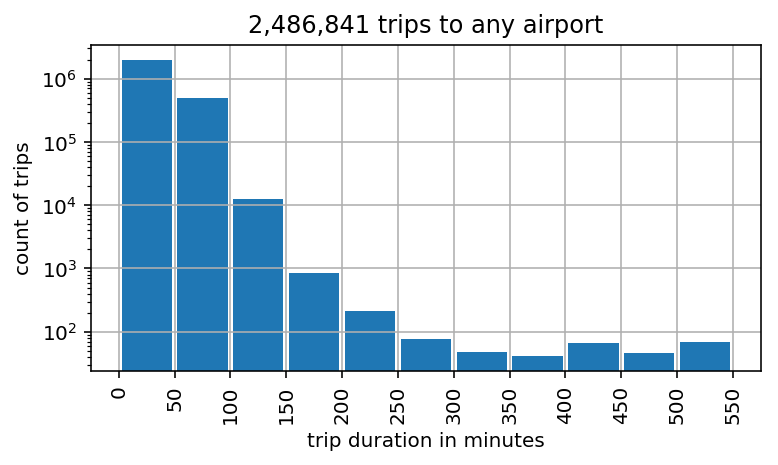

In [78]:
duration_hist(df, "trips to any airport", y_scale_log=1)

Looks better. Most trips to less than 100 minutes.
But I want to know it more precisely.
What is the 99% percentile of the trip duration? 

In [79]:
df.trip_duration_minutes.quantile(.99)

93.03333333333333

So 99% of all yellow taxi trips in NYC in 2017 to one of the three airports, took 93 minutes or less.
Only 1% of them took longer than 93 minutes.

Now lets zoom in and reduce to trips heading to Newark Airport.

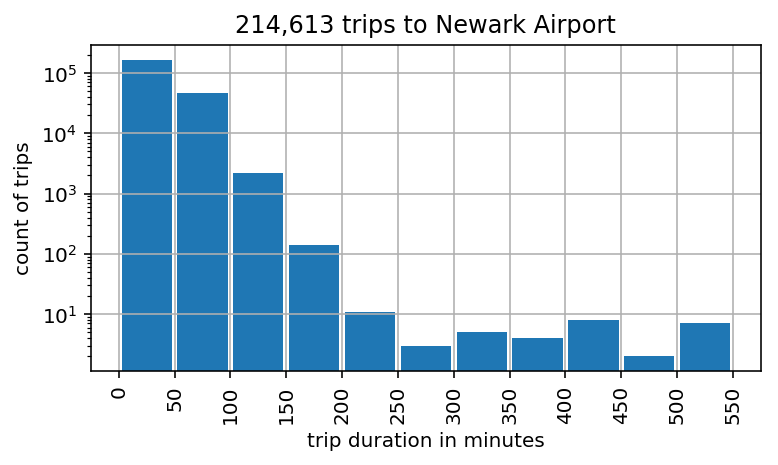

In [80]:
duration_hist(df_ewr, "trips to Newark Airport", y_scale_log=1)

In [81]:
df_ewr.trip_duration_minutes.quantile(.99)

101.66666666666667

And zoom further: trips starting in Murray Hill heading to Newark Airport.

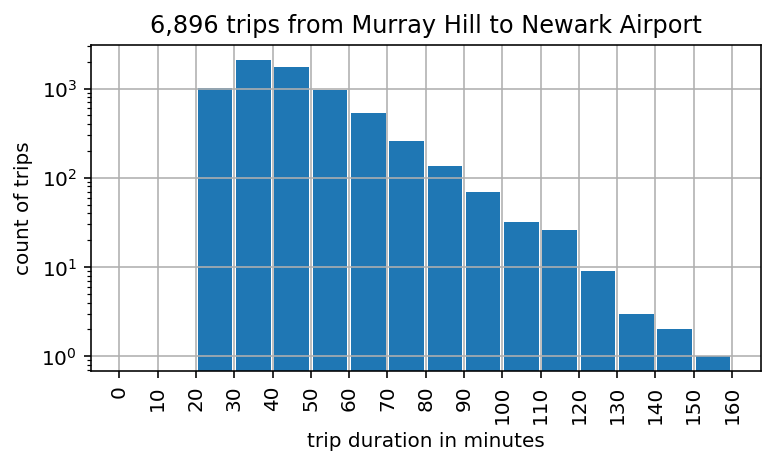

In [82]:
duration_hist(df_mh_ewr, "trips from Murray Hill to Newark Airport", y_scale_log=1)

In [83]:
df_mh_ewr.trip_duration_minutes.quantile(.99)

101.65833333333347

Not so many outliers than in the previous zoom step, but the 99-percentile is pretty similar.

Maybe workdays are special.

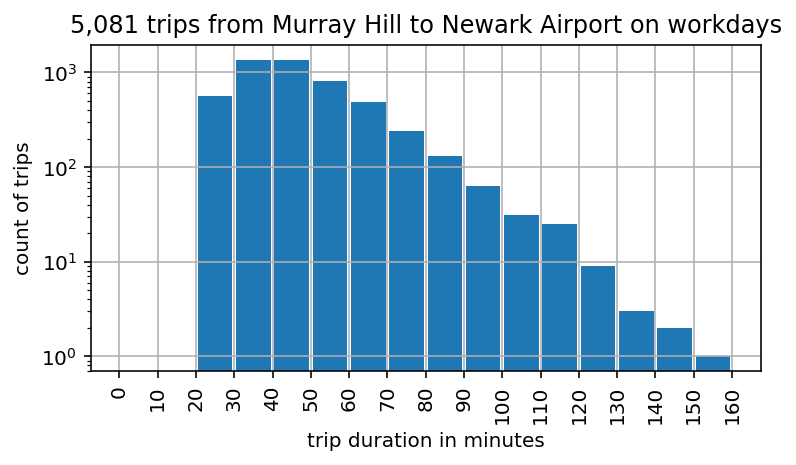

In [85]:
duration_hist(df_mh_ewr_wd, "trips from Murray Hill to Newark Airport on workdays", y_scale_log=1)

In [86]:
df_mh_ewr_wd.trip_duration_minutes.quantile(.99)

107.04333333333327

Yes, reducing to workdays raises the 99-percentile. Its 5-6 minutes longer now.
Lets look at fridays.

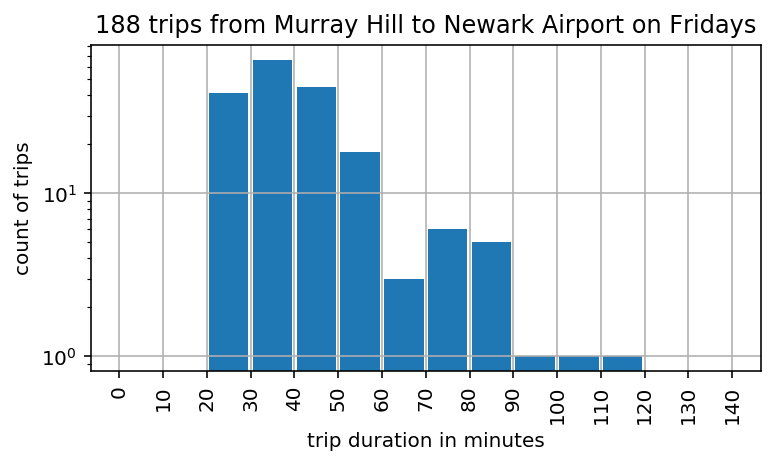

In [237]:
duration_hist(df_mh_ewr_fr, "trips from Murray Hill to Newark Airport on Fridays", y_scale_log=1)

In [87]:
df_mh_ewr_fr.trip_duration_minutes.quantile(.99)

108.56983333333328

Again a little bit longer: 1-2 minutes.

Lets look in a different direction: we tried to arrive at the airport at 17:30 to 17:50.

In [88]:
df_mh_ewr_17 = df_mh_ewr[df_mh_ewr.dropoff_hour == 17]
df_ewr_17 = df_ewr[df_ewr.dropoff_hour == 17]
df_mh_ewr_fr_17 = df_mh_ewr_fr[df_mh_ewr_fr.dropoff_hour == 17]

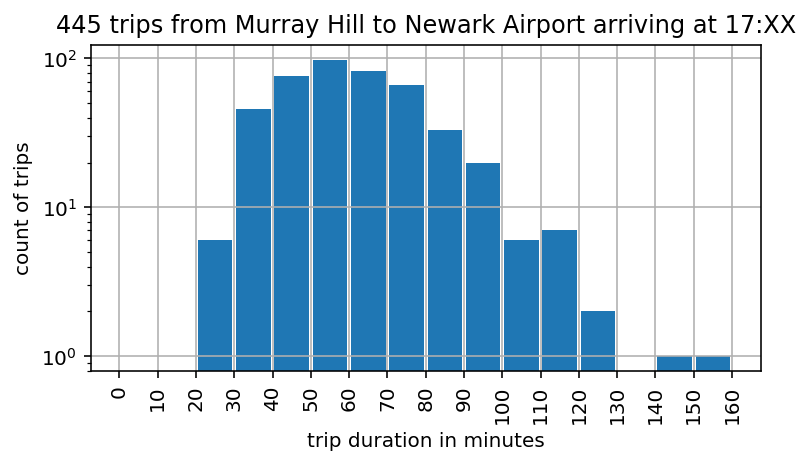

In [90]:
duration_hist(df_mh_ewr_17, "trips from Murray Hill to Newark Airport arriving at 17:XX", y_scale_log=1)

In [253]:
df_mh_ewr_17.trip_duration_minutes.quantile(.99)

123.73933333333336

Yes thats a big step:about 15 minutes longer than the overall friday percentile.

So lets use this as the reference.

## Question 2: Which of the three airports has best reachability from the quarter where we stayed this time? (Murray Hill)

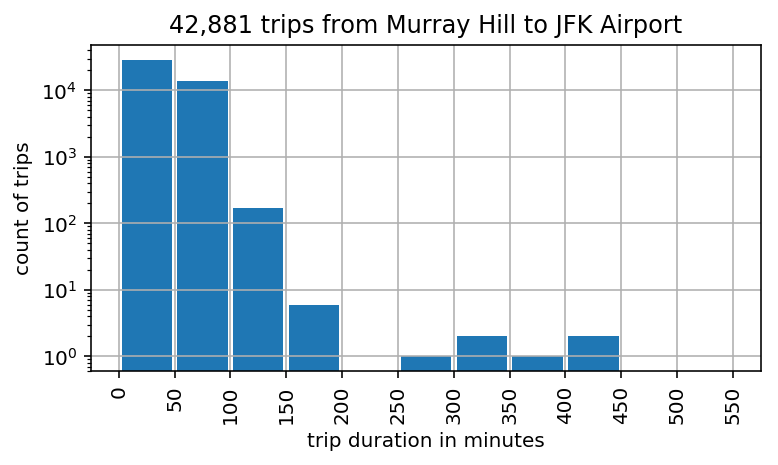

In [91]:
duration_hist(df_mh_jfk, "trips from Murray Hill to JFK Airport", y_scale_log=1)

In [92]:
df_mh_jfk.trip_duration_minutes.quantile(.99)

91.93666666666638

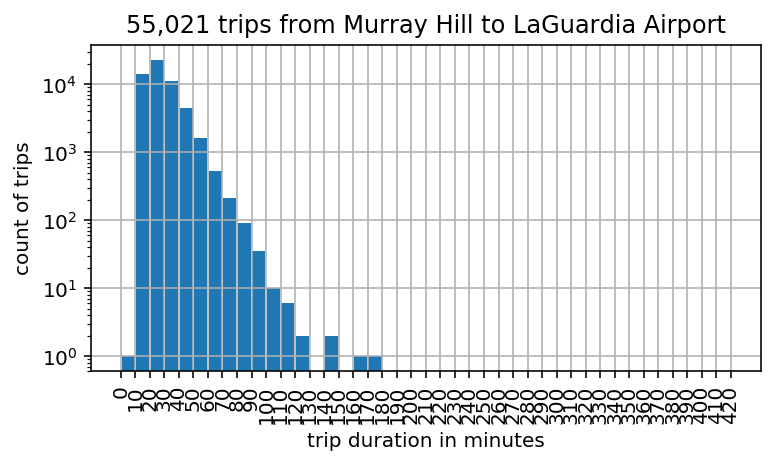

In [93]:
duration_hist(df_mh_lga, "trips from Murray Hill to LaGuardia Airport", y_scale_log=1)

The plot is ugly, because my formula for automatically scaling x seems not to work here. Let repair it, by limit trip duration to 200 minutes.

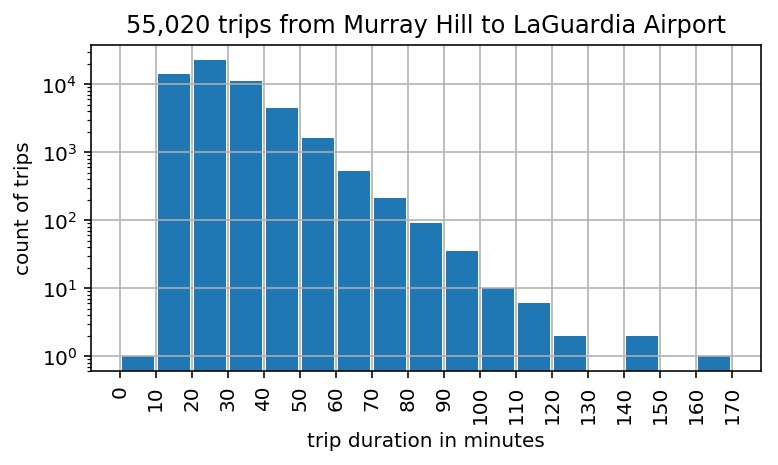

In [100]:
duration_hist(df_mh_lga[df_mh_lga.trip_duration_minutes<=200], "trips from Murray Hill to LaGuardia Airport", y_scale_log=1)

In [103]:
df_mh_lga.trip_duration_minutes.quantile(.99)

64.90666666666682

In [95]:
df_mh_ewr.trip_duration_minutes.quantile(.99)

101.65833333333347

## Question 3: Which zone in Manhattan has best reachability to Newark Airport

Collecting all zones located in Manhattan:

In [104]:
manhattan_zones = df[df.pickup_borough == 'Manhattan'].pickup_zone.unique()

Computing quantile for duration and distance given a zone and a quantile: dropoff zone os fixed to Newark Airport (EWR)

In [107]:
def transfer_duration_quantile(zone, q):
    return df_ewr[df_ewr.pickup_zone == zone].trip_duration_minutes.quantile(q)
def transfer_distance_quantile(zone, q):
    return df_ewr[df_ewr.pickup_zone == zone].trip_distance.quantile(q)

And applying that to compute them for transfer (xfer) time and distance for every manhattan zone.

In [113]:
ewr_xfer_time_99perc = pd.Series()
ewr_xfer_distance_99perc = pd.Series()
for z in manhattan_zones:
    ewr_xfer_time_99perc[z] = transfer_duration_quantile(z, .99)
    ewr_xfer_distance_99perc[z] = transfer_distance_quantile(z, .99)
ewr_xfer_time_99perc = ewr_xfer_time_99perc.sort_values()


The top ten zones with smallest transfer time to Newark Airport are:

In [114]:
ewr_xfer_time_99perc[:10]

Highbridge Park              52.943333
Inwood                       64.182667
Washington Heights South     64.396667
Manhattanville               69.159333
Washington Heights North     70.910000
Hudson Sq                    78.220000
West Chelsea/Hudson Yards    83.563667
Garment District             83.631333
Clinton East                 83.733333
Clinton West                 84.641667
dtype: float64

The worst 10 zones with highest transfer time are:

In [115]:
ewr_xfer_time_99perc[-10:]

Randalls Island                                  112.924167
Yorkville West                                   113.589500
Yorkville East                                   113.810667
East Harlem North                                117.877333
Two Bridges/Seward Park                          119.804000
Financial District South                         125.490333
Inwood Hill Park                                        NaN
Roosevelt Island                                        NaN
Marble Hill                                             NaN
Governor's Island/Ellis Island/Liberty Island           NaN
dtype: float64

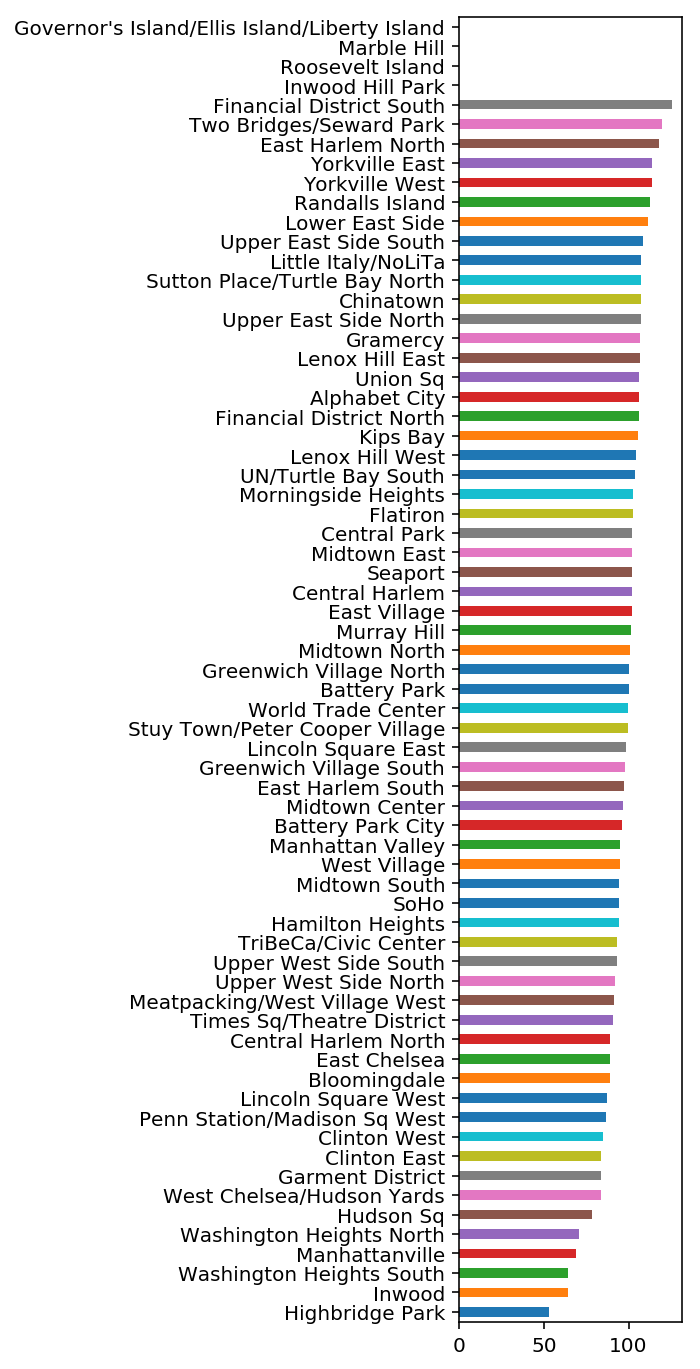

In [116]:
plt.figure(figsize=(2,12))
ewr_xfer_time_99perc.plot.barh()

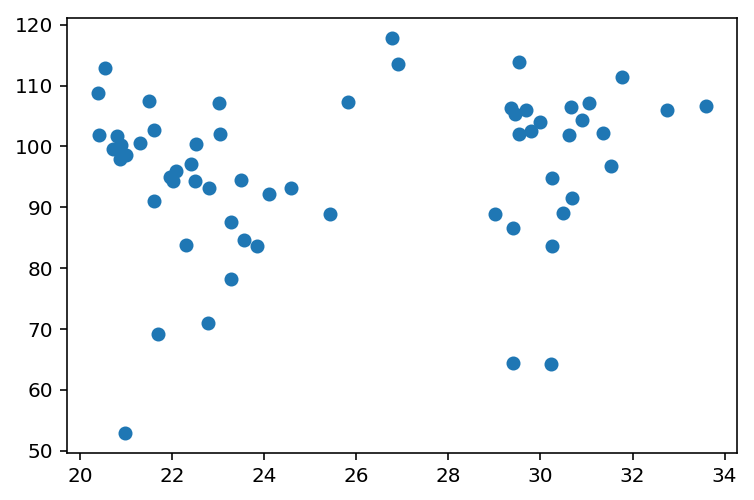

In [118]:
plt.scatter(x=ewr_xfer_distance_99perc, y=ewr_xfer_time_99perc)

In [ ]:
x